In [1]:
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string

# VEST Georgia Validation

## Examining and Loading Files

### VEST

#### Copy in VEST GA 16 file

In [2]:
vest_ga = gp.read_file("./raw-from-source/VEST/ga_2016/ga_2016.shp")

## To Do: Check if VEST has any 0 population / vote precincts

#### VEST Data Sources (from documentation):

Election results from the Georgia Secretary of State Elections Division  (https://sos.ga.gov/index.php/Elections/current_and_past_elections_results)  
Precinct shapefile primarily from the Georgia General Assembly Reapportionment Office (http://www.legis.ga.gov/Joint/reapportionment/en-US/default.aspx)  

#### VEST Field Names (from documentation):

G16PRERTRU - Donald J. Trump (Republican Party)  
G16PREDCLI - Hillary Clinton (Democratic Party)  
G16PRELJOH - Gary Johnson (Libertarian Party)  
  
G16USSRISA - Johnny Isakson (Republican Party)  
G16USSDBAR - Jim Barksdale (Democratic Party)  
G16USSLBUC - Allen Buckley (Libertarian Party)  
  
G16PSCRECH - Tim Echols (Republican Party)  
G16PSCLHOS - Eric Hoskins (Libertarian Party)  

Note: Some difficulties in using the link provided by VEST (need to do work on each county)

### MEDSL Presidential Election Precinct-Level Results

In [3]:
#Note: Some difficulties in using the link provided by VEST (need to do work on each county)
medsl_election = pd.read_csv("./raw-from-source/MEDSL/2016-precinct-president.tab",sep="\t")
medsl_election= medsl_election[medsl_election.state=="Georgia"]
medsl_election= medsl_election[["county_name","county_fips",'jurisdiction', 'precinct', 'candidate',
       'candidate_normalized', 'office', 'district', 'writein', 'party',
       'mode', 'votes','candidate_fec', 'candidate_fec_name']]
candidate_list = ['CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE',
 'JOHNSON, JOHN FITZGERALD MR.', 'TRUMP, DONALD J. / MICHAEL R. PENCE']
medsl_election=medsl_election[medsl_election["candidate_fec_name"].isin(candidate_list)]
medsl_election['county_fips'] = medsl_election['county_fips'].astype(int)
medsl_election['county_fips'] = medsl_election['county_fips'].astype(str)
medsl_election["precinct"]=medsl_election["precinct"].str.strip()
medsl_election['county_prec'] = medsl_election['county_fips'].str[2:5]+medsl_election["precinct"]
medsl_election=pd.pivot_table(medsl_election,index=['county_prec'],columns=["candidate_fec_name"],values=['votes'],aggfunc=sum)
medsl_election.columns = medsl_election.columns.droplevel(0)
medsl_election = medsl_election.rename(columns={"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE":"G16PREDCLI","JOHNSON, JOHN FITZGERALD MR.":"G16PRELJOH","TRUMP, DONALD J. / MICHAEL R. PENCE": "G16PRERTRU"})

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (13,17,19,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### MEDSL State Elections Precinct-Level Results

In [4]:
medsl_state_election = pd.read_csv("./raw-from-source/MEDSL/2016-precinct-state.tab",sep="\t")
medsl_state_election= medsl_state_election[medsl_state_election.state=="Georgia"]
medsl_state_election= medsl_state_election[["county_name","county_fips",'jurisdiction', 'precinct', 'candidate',
       'candidate_normalized', 'office', 'district', 'writein', 'party',
       'mode', 'votes','candidate_fec', 'candidate_fec_name']]
medsl_state_election = medsl_state_election[medsl_state_election["office"]=="PUBLIC SERVICE COMMISSION, DISTRICT 2 - EASTERN"]
medsl_state_election['county_fips'] = medsl_state_election['county_fips'].astype(int)
medsl_state_election['county_fips'] = medsl_state_election['county_fips'].astype(str)
medsl_state_election["precinct"]=medsl_state_election["precinct"].str.strip()
medsl_state_election['county_prec'] = medsl_state_election['county_fips'].str[2:5]+medsl_state_election["precinct"]
medsl_state_election=pd.pivot_table(medsl_state_election,index=['county_prec'],columns=["candidate"],values=['votes'],aggfunc=sum)
medsl_state_election.columns = medsl_state_election.columns.droplevel(0)
medsl_state_election = medsl_state_election.rename(columns={"ERIC HOSKINS":"G16PSCLHOS","TIM ECHOLS":"G16PSCRECH"})

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (7,13,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### MEDSL Senate Elections Precinct-Level Results

In [5]:
medsl_senate_election = pd.read_csv("./raw-from-source/MEDSL/2016-precinct-senate.tab",sep="\t")
medsl_senate_election= medsl_senate_election[medsl_senate_election.state=="Georgia"]
medsl_senate_election= medsl_senate_election[["county_name","county_fips",'jurisdiction', 'precinct', 'candidate',
       'candidate_normalized', 'office', 'district', 'writein', 'party',
       'mode', 'votes','candidate_fec', 'candidate_fec_name']]
medsl_senate_election['county_fips'] = medsl_senate_election['county_fips'].astype(int)
medsl_senate_election['county_fips'] = medsl_senate_election['county_fips'].astype(str)
medsl_senate_election["precinct"]=medsl_senate_election["precinct"].str.strip()
medsl_senate_election['county_prec'] = medsl_senate_election['county_fips'].str[2:5]+medsl_senate_election["precinct"]
medsl_senate_election=pd.pivot_table(medsl_senate_election,index=['county_prec'],columns=["candidate"],values=['votes'],aggfunc=sum)
medsl_senate_election.columns = medsl_senate_election.columns.droplevel(0)
medsl_senate_election = medsl_senate_election.drop('Michelle Gates', 1)
medsl_senate_election = medsl_senate_election.rename(columns={"ALLEN BUCKLEY":"G16USSLBUC","JIM BARKSDALE":"G16USSDBAR","JOHNNY ISAKSON":"G16USSRISA"})

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (13,19,27,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Check Totals

In [6]:
print("MEDSL totals:")
print(medsl_election["G16PREDCLI"].sum())
print(medsl_election["G16PRELJOH"].sum())
print(medsl_election["G16PRERTRU"].sum())
print("")
print(medsl_state_election["G16PSCLHOS"].sum())
print(medsl_state_election["G16PSCRECH"].sum())
print("")
print(medsl_senate_election["G16USSLBUC"].sum())
print(medsl_senate_election["G16USSDBAR"].sum())
print(medsl_senate_election["G16USSRISA"].sum())
print("")
print("VEST totals:")
print(vest_ga["G16PREDCLI"].sum())
print(vest_ga["G16PRELJOH"].sum())
print(vest_ga["G16PRERTRU"].sum())
print("")
print(vest_ga["G16PSCLHOS"].sum())
print(vest_ga["G16PSCRECH"].sum())
print("")
print(vest_ga["G16USSLBUC"].sum())
print(vest_ga["G16USSDBAR"].sum())
print(vest_ga["G16USSRISA"].sum())

MEDSL totals:
1877963
125306
2089104

1200076
2390836

162260.0
1599726.0
2135806.0

VEST totals:
1877963
125306
2089104

1200076
2390836

162260
1599726
2135806


### Merge MEDSL results

In [7]:
medsl_election = medsl_election.reset_index()
print(medsl_election.head())

medsl_state_election = medsl_state_election.reset_index()
print(medsl_state_election.head())

medsl_senate_election = medsl_senate_election.reset_index()
print(medsl_senate_election.head())

print(medsl_election.shape)
print(medsl_state_election.shape)
print(medsl_senate_election.shape)

candidate_fec_name county_prec  G16PREDCLI  G16PRELJOH  G16PRERTRU
0                        0011B          92           9         685
1                        0011C          42           5         496
2                         0012         742          10         427
3                        0013A           4           4         209
4                       0013A1          17           1         319
candidate county_prec  G16PSCLHOS  G16PSCRECH
0               0011B          62         655
1               0011C          41         464
2                0012         344         545
3               0013A          10         193
4              0013A1          18         300
candidate county_prec  G16USSLBUC  G16USSDBAR  G16USSRISA
0               0011B        14.0        81.0       636.0
1               0011C        13.0        45.0       455.0
2                0012        28.0       581.0       445.0
3               0013A         3.0         6.0       194.0
4              0013A1         9.

In [8]:
#Merge presidential and state election results
medsl_state_pres=pd.merge(medsl_election,medsl_state_election,on='county_prec',how='outer',indicator=True)
print(medsl_state_pres.shape)
print(medsl_state_pres)
medsl_state_pres = medsl_state_pres.drop('_merge', 1)

#Merged pres+state with senate results
medsl_all = pd.merge(medsl_state_pres,medsl_senate_election,on='county_prec',how='outer',indicator=True)
print(medsl_all.shape)
print(medsl_all[medsl_all["_merge"]=="right_only"])
medsl_final = medsl_all[medsl_all["_merge"]=="both"]
medsl_final = medsl_final.drop('_merge', 1)

#the "right_only" files seem to just be write ins


(2693, 7)
         county_prec  G16PREDCLI  G16PRELJOH  G16PRERTRU  G16PSCLHOS  \
0              0011B          92           9         685          62   
1              0011C          42           5         496          41   
2               0012         742          10         427         344   
3              0013A           4           4         209          10   
4             0013A1          17           1         319          18   
...              ...         ...         ...         ...         ...   
2688     321Shingler          47           4         337          26   
2689       321Sumner          91           3         418          80   
2690  321Sylver East         162          25         664         110   
2691    321Sylvester         905          16         562         508   
2692      321Warwick         127           6         300          71   

      G16PSCRECH _merge  
0            655   both  
1            464   both  
2            545   both  
3            193   bo

In [9]:
#Merged totals seems to match the original ones!
print("MEDSL totals:")
print(medsl_election["G16PREDCLI"].sum())
print(medsl_election["G16PRELJOH"].sum())
print(medsl_election["G16PRERTRU"].sum())
print("")
print(medsl_state_election["G16PSCLHOS"].sum())
print(medsl_state_election["G16PSCRECH"].sum())
print("")
print(medsl_senate_election["G16USSLBUC"].sum())
print(medsl_senate_election["G16USSDBAR"].sum())
print(medsl_senate_election["G16USSRISA"].sum())
print("")
print("Merged Totals:")
print(medsl_final["G16PREDCLI"].sum())
print(medsl_final["G16PRELJOH"].sum())
print(medsl_final["G16PRERTRU"].sum())
print("")
print(medsl_final["G16PSCLHOS"].sum())
print(medsl_final["G16PSCRECH"].sum())
print("")
print(medsl_final["G16USSLBUC"].sum())
print(medsl_final["G16USSDBAR"].sum())
print(medsl_final["G16USSRISA"].sum())

MEDSL totals:
1877963
125306
2089104

1200076
2390836

162260.0
1599726.0
2135806.0

Merged Totals:
1877963.0
125306.0
2089104.0

1200076.0
2390836.0

162260.0
1599726.0
2135806.0


### Shapefiles

In [10]:
precinct_shapes_ga = gp.read_file("./raw-from-source/GA_shapefile/vtd2016-shape/VTD2016-Shape.shp")
#Try 1: precinct_shapes_ga["county_prec"]=precinct_shapes_ga["FIPS2"].astype(str).str.zfill(3)+precinct_shapes_ga["PRECINCT_I"]
#Try 2: precinct_shapes_ga["county_prec"] = precinct_shapes_ga["CTYSOSID"]
#Try 3: precinct_shapes_ga["county_prec"]=precinct_shapes_ga["FIPS2"].astype(str).str.zfill(3)+precinct_shapes_ga["PRECINCT_N"]
#Try 4:
medsl_final["county_prec"]=medsl_final["county_prec"].str.upper()
precinct_shapes_ga["county_prec"]=precinct_shapes_ga["FIPS2"].astype(str).str.zfill(3)+precinct_shapes_ga["PRECINCT_N"]
#Try 5 (4 but add in a string strip to MEDSL files):

In [11]:
print(medsl_final[medsl_final["county_prec"].str[0:3]=="121"].shape)
print(precinct_shapes_ga[precinct_shapes_ga["COUNTY_NAM"]=="FULTON"].shape)
print(vest_ga[vest_ga["CTYNAME"]=="FULTON"].shape)

(346, 9)
(345, 16)
(366, 17)


#### VEST Processing (from documentation):

**1. NOT COMPLETED**  
Fulton County uses shapefiles and maps sourced from the county GIS program. Precincts CH01/CH04B, CP07A/CP07D, SS29A/SS29B, UC031/UC035 were merged to match how voters were registered in the 2016 voter file.  
- Files needed: Fulton County GIS files  
- *Note: Unable to find these shapefiles and maps through the county GIS program. Our election results and precinct data have 345 and 346 precincts for Fulton, while the final VEST file has 366.*

**2. Pending**  
The following precincts were split by congressional district to match the 2016 election results: Avondale High, Glennwood, Wadsworth in Dekalb County; Cates D in Gwinnett County.   
- Files needed: 2016 congressional map   

**3. Pending**  
Cloudland and Teloga precincts in Chattooga County were split along the ridgeline that marks the boundary between them with the USGS Topographic Contour shapefile.
- Files needed: USGS Topographic Contour shapefile      

**4. TO DO**   
Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only has one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.  
- Files needed: n/a**  
- *Note: For whatever reason, this already seems to have been done on the files*

In [12]:
#Instruction 2
us_congress = gp.read_file("./raw-from-source/Congressional_Districts/tl_2018_us_cd116/tl_2018_us_cd116.shp")
ga_congress = us_congress[us_congress["STATEFP"]=="13"]

#New names should be "AVONDALE HIGH -05 , AVONDALE HIGH -04 "
avondale_high = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="AVONDALE HIGH"]


#"GLENNWOOD - 05" and "GLENNWOOD - 04"
glennwood = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="GLENNWOOD (DEC)"]

#"WADSWORTH ELEM - 05" and "WADSWORTH ELEM - 04"
wadsworth = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="WADSWORTH"]


cates_d = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="CATES D"]

In [13]:
#Instruction #3
clouldland_teloga = precinct_shapes_ga[precinct_shapes_ga["CTYSOSID"]=="055XC-968"]
print(clouldland_teloga.head())

#Confirming it is split in the MEDSL election results
print(medsl_final[medsl_final["county_prec"].str[0:3]=="055"])

#New names should be "CLOUDLAND" and "TELOGA"

#How it is stored in VEST
print(vest_ga[vest_ga["CTYNAME"]=='CHATTOOGA'])

           ID       AREA  DATA  POPULATION   DISTRICT   CTYSOSID PRECINCT_I  \
1547  3588199  40.953088   373        1385  055XC-968  055XC-968     XC-968   

             PRECINCT_N CTYNUMBER COUNTY    CTYNAME  FIPS1 FIPS2 COUNTY_NAM  \
1547  CLOULDLAND-TELOGA        27     27  CHATTOOGA  13055    55       None   

                                               geometry           county_prec  
1547  POLYGON ((-85.40821 34.53204, -85.40823 34.531...  055CLOULDLAND-TELOGA  
        county_prec  G16PREDCLI  G16PRELJOH  G16PRERTRU  G16PSCLHOS  \
346       055ALPINE        93.0        17.0       451.0        67.0   
347    055CLOUDLAND        58.0         5.0       158.0        46.0   
348    055COLDWATER        53.0         3.0       106.0        30.0   
349   055DIRTSELLER        16.0         0.0       106.0        14.0   
350     055DIRTTOWN        96.0        11.0       455.0        73.0   
351      055HAYWOOD        15.0         3.0        89.0        17.0   
352       055LYERLY      

#### Instruction 4:
District = 215FTBEN4  
215FTBEN3  
215FTBEN2  
215FTBEN1  

**Increasing Matches**

In [14]:
changes_dict = {'321SYLVER EAST' : '321SYLVESTER EAST',
'317SENIOR CITIZEN CENTER' : '317SENIOR CITIZEN CENTE',
'317METASVILLE FIRE STATION' : '317METASVILLE FIRE STA',
'315ROCHELLE SOUTH 4' : '315ROCHELLE SOUTH #4',
'315ROCHELLE NORTH 1' : '315ROCHELLE NORTH #1',
'315PITTS 3' : '315PITTS #3',
'315PINEVIEW 2' : '315PINEVIEW #2',
'315ABBEVILLE SOUTH 5' : '315ABBEVILLE SOUTH #5',
'315ABBEVILLE NORTH 2' : '315ABBEVILLE NORTH #2',
'311MT. YONAH' : '311MT YONAH',
'305MT. PLEASANT' : '305MT PLEASANT',
'295LAFAYETTE' : '295LA FAYETTE',
'279514 S.T.I.A.L.C' : '279514 S.T.I.A.L.C.',
'27939 NEW BRANCH' : '27939 NEWBRANCH',
'277MOTT-LITTMAN GYM' : '277MOTT-LITMAN GYM',
'275MERRILLVILLE' : '275MERRILVILLE',
'275FIRE STATION 2' : '275FIRE STATION #2',
'269#6 REYNOLDS' : '269PRECINCT 6',
'269#5 COURTHOUSE' : '269PRECINCT 5',
'269#1 BUTLER FIRE DEPT.' : '269PRECINCT 1',
'261ANDERSONV' : '261ANDERSONVILLE',
'251SCREVEN REC DEPT' : '251SCREVEN REC. DEPT.',
'247STANTON' : '247ST',
'247ST. PIUS' : '247SP',
'247SMYRNA' : '247SM',
'247SHEFFIELD' : '247SH',
'247SALEM' : '247SA',
'247ROCKDALE' : '247RO',
'247OLDE TOWNE' : '247OT',
'247MILSTEAD' : '247MI',
'247MAGNET' : '247MA',
'247LORRAINE' : '247LO',
'247THE LAKES' : '247LA',
'247HIGHTOWER' : '247HI',
'247HONEY CREEK' : '247HC',
'247FLAT SHOALS' : '247FS',
'247FIELDSTONE' : '247FI',
'247CONYERS' : '247CO',
'247BETHEL' : '247BT',
'247BARKSDALE' : '247BA',
'243FOUNTAIN BRIDGE-4TH' : '243FOUNTAIN BRIDGE',
'241RABUN' : '241RABUN COUNTY',
'215ST PETER U. M. C.' : '215ST. PETER',
'215NATIONAL INFANTRY' : '215NATIONAL INFANTRY MUSEUM',
'215ST. MARK/HEIFERHORN' : '215ST MARK/HEIFERHORN',
'215ST. ANDREWS/MIDLAND' : '215ST ANDREWS/MIDLAND',
'215MT. PILGRIM' : '215MT PILGRIM',
'215GALLOPS/HANNAN' : '215MARIANNA GALLOPS',
'215CORNERSTONE CHURCH' : '215CORNERSTONE',
'215BRITT DAVID BAPT CH' : '215BRITT DAVID',
'211WEST MORGAN' : '2116. WEST MORGAN',
'211NORTHEAST MORGAN' : '2111. NORTHEAST MORGAN',
'211NORTH MORGAN' : '2117. NORTH MORGAN',
'211EAST MORGAN' : '2112. EAST MORGAN',
'211CLACKS CHAPEL' : '2115. CLACKS CHAPEL',
'211CENTRAL MORGAN' : '2114. CENTRAL MORGAN',
'211BETH/SPRINGFIELD' : '2113. BETH/SPRINGFIELD',
'205HISONTON' : '205HINSONTON',
'199WOODBURY' : '199LOWER 9TH-WOODBURY',
'199WARM SPRINGS' : '1992ND-WARM SPRINGS',
'199ODESSADALE' : '1997TH-ODESSADALE',
'199MANCHESTER GILL II' : '199GILL II',
'199MANCHESTER GILL I' : '199GILL I',
'199GREENVILLE' : '1998TH-GREENVILLE',
'199GAY' : '199MIDDLE 9TH-GAY',
'199DURAND' : '199THIRD-DURAND',
'199ALVATON' : '199UPPER 9TH -ALVATON',
'197FT. PERRY' : '197FORT PERRY',
'193MONTEZUMA 5' : '193MONTEZUMA #5',
'193MONTEZUMA 4' : '193MONTEZUMA #4',
'179LIBERTY COUNTY' : '179LIBERTY COUNTY COMPLEX',
'179HINESVILLE LODGE' : '179HINESVILLE LODGE 271',
'177SOVEREIGN GRACE' : '177#8 SOVEREIGN GRACE',
'177SMITHVILLE' : '177#2 SMITHVILLE',
'177SDA CHURCH' : '177#7 SDA CHURCH',
'177REDBONE' : '177#10 REDBONE',
'177LEESBURG' : '177#4 LEESBURG',
'177FRIENDSHIP BAPT' : '177#5 FRIENDSHIP BAPT.',
'177FIRST BAPTIST' : '177#6 FIRST BAPTIST',
'177CJC' : '177#3 CJC',
'177CHOKEE' : '177#1 CHOKEE',
'177CENTURY FIRE STATION' : '177#9 CENTURY FIRE STAT',
'175LCFS 10 (VALAMBROSIA)' : '175LCFS #10 (VALAMBROSIA)',
'175FAMILY LIFE CENTER' : '175FBC - FLC',
'171SENIOR CITZEN BLDG' : '171SENIOR CITIZEN BLDG',
'161HAZELHURST' : '161HAZLEHURST',
'157SOUTH MINISH' : '157S MINISH',
'157SOUTH JEFFERSON' : '157S JEFFERSON',
'157NORTH MINISH' : '157N MINISH',
'157NORTH JEFFERSON' : '157N JEFFERSON',
'151MT. CARMEL' : '151MOUNT CARMEL',
'141MAYFIELD COMM CENTER' : '141MAYFIELD COMMUNITY CENTER',
'13931-FRIENDSHIP IV' : '139FRIENDSHIP IV',
'13930-FRIENDSHIP III' : '139FRIENDSHIP III',
'13929-FRIENDSHIP II' : '139FRIENDSHIP II',
'13928-FRIENDSHIP I' : '139FRIENDSHIP I',
'13927-BIG HICKORY' : '139BIG HICKORY',
'13926-GILLSVILLE' : '139GILLSVILLE',
'13925-GAINESVILLE V' : '139GAINESVILLE V',
'13924-GAINESVILLE IV' : '139GAINESVILLE IV',
'13923-GAINESVILLE III' : '139GAINESVILLE III',
'13922-GAINESVILLE II' : '139GAINESVILLE II',
'13921-GAINESVILLE I' : '139GAINESVILLE I',
'13920-WEST WHELCHEL' : '139WEST WHELCHEL',
'13919-WHELCHEL' : '139WHELCHEL',
'13918-FORK' : '139FORK',
'13917-CHESTATEE' : '139CHESTATEE',
'13916-BARK CAMP' : '139BARK CAMP',
'13915-QUILLIANS' : '139QUILLIANS',
'13914-CLERMONT' : '139CLERMONT',
'13913-LULA' : '139LULA',
'13912-GLADE' : '139GLADE',
'13911-TADMORE' : '139TADMORE',
'13910-CANDLER' : '139CANDLER',
'13909-MORGAN II' : '139MORGAN II',
'13908-MORGAN I' : '139MORGAN I',
'13907-ROBERTS' : '139ROBERTS',
'13906-FLOWERY BRANCH II' : '139FLOWERY BRANCH II',
'13905-FLOWERY BRANCH I' : '139FLOWERY BRANCH I',
'13904-OAKWOOD II' : '139OAKWOOD II',
'13903-OAKWOOD I' : '139OAKWOOD I',
'13902-CHICOPEE' : '139CHICOPEE',
'13901-WILSON' : '139WILSON',
'131CAIRO 5TH DISTRICT' : '131CAIRO 5TH DISTR',
'131CAIRO 4TH DISTRICT' : '131CAIRO 4TH DISTR',
'127STERLING ELEM SCHOOL' : '127STERLING ELEMENTARY',
'127STERLING CHURCH OF GOD' : '127STERLING CH. OF GOD',
'127BURROUGHS' : '127BURROUGHS MOLETTE',
'127BALLARD COMPLEX' : '127BALLARD COMMUNITY BUILDING',
'099LUCILLE' : '099LUCILE',
'097FIRST BAPTIST CHURCH' : '097FIRST BAPTIST DOUGLASVILLE',
'097FIRST BAPTIST - LITHIA SPRINGS' : '097FIRST BAPTIST LITHIA SPRINGS',
'097DAY STAR' : '097DAY STAR GYM',
'097COUNTY LINE BAPTIST CHURCH' : '097COUNTY LINE BAPTIST',
'097CHURCH-CH' : '097CHURCH AT CHAPEL HILL',
'097BEULAH' : '097BEULAH BAPTIST CHURCH',
'095SHILOH BAPTIST CHURCH' : '095SHILOH BAPTIST CHURC',
'095SECOND MT. ZION' : '0952ND MT ZION CHURCH',
'095PUTNEY 1ST BAPT CHURCH' : '095PUTNEY 1ST BAPT CHUR',
'095PINE BLUFF BAPT CHURCH' : '095PINE BLUFF BAPT CHUR',
'095PHOEBE EDU. BLDG' : '095PHOEBE EDUCATION BLD',
'095PALMYRA RD METH CHURCH' : '095PALMYRA METH CHURCH',
'095MT. ZION CENTER' : '095MT ZION CENTER',
'095LAMAR REESE ELEM SCHOOL' : '095LAMAR REESE ELEM SCH',
'095FIRST CHRISTIAN CHURCH' : '0951ST CHRISTIAN CHURCH',
'095COVENANT PRES CHURCH' : '095COVENANT CHURCH',
'091YONKER' : '091YONKE',
'091VILULA' : '091VILUL',
'091RAWLINS' : '091RAWLI',
'091PONDTOWN' : '091PONDT',
'091PLAINFIELD' : '091PLAIN',
'091MULLIS' : '091MULLI',
'091MITCHELL' : '091MITCH',
'091MCCRANIE' : '091MCCRA',
'091JAYBIRD' : '091JAYBI',
'091EMPIRE' : '091EMPIR',
'091CHAUNCEY' : '091CHAUN',
'089WOODWARD ELEM' : '089WOODWARD (BHAVN)',
'089WINTERS CHAPEL' : '089WINTERS CHAPEL (DUN)',
'089WINNONA PARK ELEM' : '089WINNONA PARK ELEM (DEC)',
'089WHITEFOORD ELEM' : '089WHITEFOORD ELEM (ATL)',
'089TILLY MILL ROAD' : '089TILLY MILL ROAD (DUN)',
'089TERRY MILL ELEM' : '089TERRY MILL',
'089STONE MOUNTAIN MIDDLE' : '089STN MTN MIDDLE',
'089STONE MOUNTAIN LIBRARY' : '089STONE MTN LIBRARY  (STO)',
'089STONE MOUNTAIN CHAMPION' : '089STONE MTN CHAMPION (STO)',
'089SNAPFINGER ROAD SOUTH' : '089SNAPFINGER ROAD S',
'089SNAPFINGER ROAD NORTH' : '089SNAPFINGER ROAD N',
'089SMOKE RISE ELEM' : '089SMOKE RISE',
'089SKYLAND' : '089SKYLAND (BHAVN)',
'089SILVER LAKE' : '089SILVER LAKE (BHAVN)',
'089ROCKBRIDGE ELEM' : '089ROCKBRIDGE',
'089RENFROE MIDDLE' : '089RENFROE MIDDLE (DEC)',
'089PONCE DE LEON' : '089PONCE DE LEON (DEC)',
'089PLEASANTDALE ELEM' : '089PLEASANTDALE ROAD',
'089PINE LAKE' : '089PINE LAKE (PIN)',
'089PEACHTREE MIDDLE' : '089PEACHTREE MIDDLE (DUN)',
'089PEACHCREST ELEM' : '089PEACHCREST',
'089OAKHURST' : '089OAKHURST (DEC)',
'089NORTH PEACHTREE' : '089NORTH PEACHTREE (DUN)',
'089MT. VERNON WEST' : '089MOUNT VERNON WEST (DUN)',
'089MT. VERNON EAST' : '089MOUNT VERNON EAST (DUN)',
'089MONTGOMERY ELEM' : '089MONTGOMERY ELEM  (BHAVN)',
'089MILLER-ELDRIDGE L. MILLER ELEM' : '089MILLER-ELDRIDGE L MILLER ELEM',
'089MILLER GROVE MIDDLE' : '089MILLER GROVE',
'089MIDWAY ELEM' : '089MIDWAY',
'089METROPOLITAN' : '089METROPOLITAN (ATL)',
'089MEDLOCK ELEM' : '089MEDLOCK',
'089MEADOWVIEW ELEM' : '089MEADOWVIEW',
'089MCNAIR MIDDLE' : '089MCNAIR',
'089LITHONIA' : '089LITHONIA (LIT)',
'089LIN-MARY LIN ELEM' : '089LIN-MARY LIN ELEM (ATL)',
'089KNOLLWOOD ELEM' : '089KNOLLWOOD',
'089KITTREDGE ELEM' : '089KITTREDGE ELEM (BHAVN)',
'089KINGSLEY ELEM' : '089KINGSLEY ELEM (DUN)',
'089JOHNSON ESTATES' : '089JOHNSON ESTATES (ATL)',
'089IDLEWOOD ELEM' : '089IDLEWOOD ELEM (TUC)',
'089HUNTLEY HILLS ELEM' : '089HUNTLEY HILLS ELEM (CHA)',
'089HARRIS-NARVIE J. HARRIS ELEM' : '089NARVIE J HARRIS ELEM',
'089GEORGETOWN SQUARE' : '089GEORGETOWN SQ (DUN)',
'089EPWORTH' : '089EPWORTH (ATL)',
'089EAST LAKE ELEM' : '089EAST LAKE (ATL)',
'089DUNWOODY LIBRARY' : '089DUNWOODY LIBRARY (DUN)',
'089DUNWOODY HIGH' : '089DUNWOODY HIGH (DUN)',
'089DUNWOODY' : '089DUNWOODY (DUN)',
'089DRESDEN ELEM' : '089DRESDEN ELEM (CHA)',
'089DORAVILLE SOUTH' : '089DORAVILLE SOUTH (DOR)',
'089DORAVILLE NORTH' : '089DORAVILLE NORTH (DOR)',
'089CROSS KEYS HIGH' : '089CROSS KEYS HIGH (BHAVN)',
'089COVINGTON HWY LIBRARY' : '089COVINGTON HWY',
'089CLIFTON ELEM' : '089CLIFTON',
'089CLARKSTON' : '089CLARKSTON (CLA)',
'089CLAIREMONT WEST' : '089CLAIREMONT WEST (DEC)',
'089CLAIREMONT EAST' : '089CLAIREMONT EAST (DEC)',
'089CHESNUT ELEM' : '089CHESNUT ELEM (DUN)',
'089CHAMBLEE 2' : '089CHAMBLEE 2 (CHA)',
'089CHAMBLEE' : '089CHAMBLEE (CHA)',
'089BURGESS ELEM' : '089BURGESS ELEM (ATL)',
'089BROOKHAVEN' : '089BROOKHAVEN (BHAVN)',
'089BROCKETT ELEM' : '089BROCKETT ELEM (TUC)',
'089BROCKETT' : '089BROCKETT (TUC)',
'089BRIARWOOD' : '089BRIARWOOD (BHAVN)',
'089BOULEVARD' : '089BOULEVARD (ATL)',
'089BOULDERCREST RD' : '089BOULDERCREST ROAD',
'089AVONDALE' : '089AVONDALE (AVO)',
'089AUSTIN' : '089AUSTIN (DUN)',
'089ASHFORD PARKSIDE' : '089ASHFORD PARKSIDE (BHAVN)',
'089ASHFORD PARK ELEM' : '089ASHFORD PARK ELEM (BHAVN)',
'089ASHFORD DUNWOODY RD' : '089ASHFORD DUNWOODY RD (BHAVN)',
'087MT PLEASANT' : '087MT. PLEASANT',
'087BRIDGE-FAIRGROUNDS' : '087BDGE-FAIRGROUNDS',
'075NEW LIFE BAPT. CHURCH' : '075NEW LIFE BAPTIST CH.',
'073WOODLAWN BAPTIST CHURCH' : '073WOODLAWN BAPT CHURCH',
'073WARREN BAPTIST CHURCH - GROVETOWN' : '073WARREN BAPTIST CHURCH-GROVETOWN',
'073SECOND MT CARMEL BAPT CHURCH' : '073SECOND MT. CARMEL BAPTIST CHURCH',
'073MTZ COL FIRE HDQTR' : '073MTZ COL FIRE HDQTR.',
'073MARVIN METHODIST CHURCH' : '073MARVIN METHODIST',
'073LEWIS METHODIST CHURCH' : '073LEWIS METHODIST',
'073GROVETOWN MIDDLE SCHOOL' : '073GROVETOWN MIDDLE SCH',
'073GROVETOWN METHODIST CHURCH' : '073GROVETOWN METHODIST',
'073EUBANK/BLANCHARD CENTER' : '073EUBANK/BLANCHARD CTR',
'073DAMASCUS BAPTIST CHURCH' : '073DAMASCUS BAPT CHURCH',
'073COL CTY BD OF EDU' : '073COL CTY BOARD OF EDU',
'073CHRIST THE KING LUTH CH' : '073CHRIST THE KING CH',
'073CHRIST CHURCH' : '073CHRIST CHURCH, PRESBYTERIAN',
'073BLUE RIDGE ELEMENTARY' : '073BLUERIDGE ELEMENTARY',
'067WILEO 01' : '067WILLEO 01',
'067VAUGHN 01' : '067VAUGHAN 01',
'067SHALLOWFORD FALL 01' : '067SHALLOWFORD FALLS 01',
'067ROCKY MOUNTAIN 01' : '067ROCKY MOUNT 01',
'067MOUNT BETHEL 04' : '067MT BETHEL 04',
'067MOUNT BETHEL 03' : '067MT BETHEL 03',
'067MOUNT BETHEL 01' : '067MT BETHEL 01',
'067LASSSITER 01' : '067LASSITER 01',
'067HARMONY LELAND 01' : '067HARMONY-LELAND 01',
"061DAY'S CROSS ROADS" : '061DAYS CROSS ROAD',
'061COURTHOUSE' : '061COURT HOUSE',
'0518-15 GARDEN CITY RECREATION CENTER' : '051GARDEN CITY REC CTR',
'0518-13 SAVANNAH CHRISTIAN SCHOOL' : '051SAVANNAH CHRISTIAN S',
'0518-12 BEACH HIGH SCHOOL' : '051BEACH HIGH SCHOOL',
'0518-11 BUTLER SCHOOL' : '051BUTLER ELEMENTARY SC',
'0518-10 CARVER HEIGHTS COMMUNITY CENTER' : '051CARVER HEIGHTS COMM',
'0518-09 MOSES JACKSON CENTER' : '051MOSES JACKSON CENTER',
'0518-08 RESURRECTION OF OUR LORD CHURCH' : '051RESURRECTION OF OUR LORD CATHOLIC CHURCH',
'0518-07 WOODVILLE TOMPKINS TECHNICAL INSTITUTE' : '051WOODVILLE-TOMPKINS TECHNICAL INST',
'0518-05 W BROAD YMCA' : '051WEST BROAD STREET YMCA',
'0518-03 SILK HOPE BAPTIST CHURCH' : '051SILK HOPE BAPTIST CHURCH',
'0518-01 CIVIC CENTER' : '051CIVIC CENTER',
'0517-14 COASTAL CATHEDRAL CHURCH OF GOD' : '051COASTAL CATHEDRAL',
'0517-12 POOLER CHURCH' : '051POOLER CHRURCH',
'0517-11 SAVANNAH FIRST SEVENTH DAY ADVENTIST CHURCH' : '051SEVENTH DAY ADV CHR',
'0517-10 PROGRESSIVE RECREATION' : '051PROGRESSIVE REC CTR',
'0517-08 BLOOMINGDALE COMMUNITY CENTER' : '051BLOOMINGDALE COMMUNITY CENTER',
'0517-07 ROTHWELL BAPTIST CHURCH' : '051ROTHWELL BAPTIST CHURCH',
'0517-06 POOLER CITY HALL' : '051POOLER CITY HALL',
'0517-05 WOODLAWN BAPTIST CHURCH' : '051WOODLAWN BAPTIST CHURCH',
'0517-04 LAKESHORE COMMUNITY CENTER' : '051LAKE SHORE COMMUNITY CENTER',
'0517-03 PRESTON B. EDWARDS GYMNASIUM' : '051PB EDWARDS GYMNASIUM',
'0517-01 GARDEN CITY SENIOR CENTER' : '051GARDEN CITY SENIOR CENTER',
'0516-10 GEORGETOWN ELEMENTARY' : '051GEORGETOWN ELEMENTAR',
'0516-09 TRINITY LUTHERAN CHURCH' : '051TRINITY LUTHERAN CHURCH',
'0516-06 THE LIGHT' : '051THE LIGHT CHURCH',
'0516-05 WINDSOR ELEM./ GOLDEN AGE' : '051WINDSOR FOREST ELEM/GOLDEN AGE CENTER',
'0516-03 CRUSADER COMMUNITY CENTER' : '051CRUSADER COMMUNITY CENTER',
'0516-02 WINDSOR FOREST BAPTIST SCHOOL' : '051WINDSOR FOREST BAPTIST CHURCH SCHOOL',
'0516-01 WHITE BLUFF PRESBYTERIAN CHURCH' : '051WHITE BLUFF PRESBYTERIAN CHURCH',
'0515-11 LARGO TIBET SCHOOL' : '051LARGO-TIBET ELEMENTA',
'0515-10 JONESVILLE BAPTIST CHURCH' : '051JONESVILLE BAPT CH',
'0515-08 SAVANNAH PRIMITIVE BAPTIST CHURCH' : '051SAVANNAH PRIMITIVE BAPTIST CHURCH',
'0515-07 ELKS LODGE' : '051ELKS LODGE',
'0515-06 SEED CHURCH' : '051SEED CHURCH',
'0515-05 LIBERTY CITY COMMUNITY CENTER' : '051LIBERTY CITY COMMUNITY CENTER',
'0515-03 BUTLER PRESBYTERIAN ED. BUILDING' : '051BUTLER PRESBYTERIAN CHURCH ED BLDG',
'0515-02 SENIOR CITIZENS CENTER' : '051SENIOR CITIZEN CENTER',
'0515-01 BARTLETT MIDDLE SCHOOL' : '051BARTLETT MIDDLE SCHOOL',
'0514-15 SKIDAWAY ISLAND STATE PARK' : '051SKIDAWAY ISLAND STAT',
'0514-14 SKIDAWAY ISLAND METHODIST CHURCH' : '051SKID METHODIST CH',
'0514-13 SKIDAWAY ISLAND PRESBYTERIAN CHURCH' : '051SKID IS PRES CHURCH',
'0514-12 ST. PETERS EPISCOPAL CHURCH' : '051ST PETERS EPISCOPAL',
'0514-11 TYBEE SCHOOL CAFETERIA' : '051TYBEE IS SCH CAFE',
'0514-10 GUARD HOUSE COMMUNITY CENTER' : '051GUARD HOUSE COMM CTR',
'0514-08 WILMINGTON ISLAND PRESBYTERIAN CHURCH' : '051WILMINGTON ISLAND PRESBYTERIAN CHURCH',
'0514-07 WILMINGTON ISLAND METHODIST CHURCH' : '051WILMINGTON ISLAND UNITED METHODIST CHURCH',
'0514-06 FIRST BAPTIST CHURCH OF ISLAND' : '051FIRST BAPTIST CHURCH OF THE ISLAND',
'0514-05 SAINT FRANCIS EPISCOPAL' : '051SAINT FRANCIS EPISCOPAL CHURCH',
'0514-04 LIGHTHOUSE BAPTIST CHURCH' : '051LIGHTHOUSE BAPTIST CHURCH',
'0514-02 FRANK MURRAY COMMUNITY CENTER' : '051FRANK MURRAY COMMUNITY CENTER',
'0513-13 NEW COVENANT SEVENTH DAY ADVENTIST CHURCH' : '051NEW COV 7 DAY ADV CH',
'0513-12 THUNDERBOLT MUNICIPAL COMPLEX' : '051THUNDERBOLT MUN COMP',
'0513-11 SOUTHSIDE BAPTIST CHURCH' : '051SOUTHSIDE BAPTIST CH',
'0513-10 BIBLE BAPTIST CHURCH' : '051BIBLE BAPTIST CHURCH',
'0513-09 COKESBURY METHODIST CHURCH' : '051COKESBURY METHODIST CHURCH',
'0513-08 JENKINS HIGH SCHOOL' : '051JENKINS HIGH SCHOOL',
'0513-05 ALDERSGATE YOUTH CENTER' : '051ALDERSGATE YOUTH CENTER',
'0513-04 1ST AFRICAN BAPTIST CHURCH' : '051FIRST AFRICAN BAPTIST CHURCH',
'0513-03 SAVANNAH HIGH SCHOOL' : '051SAVANNAH HIGH SCHOOL',
'0513-02 ROSE OF SHARON' : '051ROSE OF SHARON',
'0513-01 OLD COURTHOUSE' : '051OLD COURTHOUSE',
'0512-12 WILLIAMS COURT' : '051WILLIAMS COURT APTS',
'0512-09 SALVATION ARMY' : '051SALVATION ARMY',
'0512-07 CHRIST COMMUNITY CHURCH AT MORNINGSIDE' : '051CHRIST COMMUNITY CHURCH AT MORNINGSIDE',
'0512-05 HOLY SPIRIT LUTHERAN CHURCH' : '051HOLY SPIRIT LUTHERAN CHURCH',
'0512-04 FELLOWSHIP OF LOVE COMMUNITY CHURCH' : '051FELLOWSHIP OF LOVE COMMUNITY CHURCH',
'0512-03 W. W. LAW CENTER' : '051W W LAW CENTER',
'0512-02 BLACKSHEAR COMMUNITY CENTER' : '051BLACKSHEAR COMMUNITY CENTER',
'0511-17 ISLANDS CHRISTIAN CHURCH' : '051ISLANDS CHRISTIAN CH',
'0511-16 FERGUSON AVE BAPTIST CHURCH' : '051FERGUSON AVE BAPTIST',
'0511-14 ST. LUKE UNITED METHODIST CHURCH' : '051ST LUKE CHURCH',
'0511-13 THE SANCTUARY' : '051THE SANCTUARY',
'0511-12 ISLE OF HOPE BAPTIST CENTER' : '051ISLE OF HOPE BAPTIST',
'0511-09 IMMANUEL BAPTIST CHURCH' : '051IMMANUEL BAPTIST CHURCH',
'0511-08 GRACE UNITED METHODIST CHURCH' : '051GRACE UNITED METHODIST CHURCH',
'0511-06 CENTRAL CHURCH OF CHRIST' : '051CENTRAL CHURCH OF CHRIST',
'0511-05 J E A BUILDING' : '051JEA BUILDING',
'0511-01 FIRST PRESBYTERIAN CHURCH' : '051FIRST PRESBYTERIAN CHURCH',
'047FORT OGLETHORPE' : '047FT OGLETHORPE',
'045WHITESBURG (682)' : '045WHITESBURG',
'045WEST CARROLLTON (714A1)' : '045WEST CARROLLTON',
'045VILLA RICA CITY (642)' : '045VILLA RICA CITY',
'045V R COUNTY SOUTH (640)' : '045V R COUNTY SOUTH',
'045V R COUNTY NORTH (641)' : '045V R COUNTY NORTH',
'045UNIVERSITY OF W. GA (714A4)' : '045UNIVERSITY OF W. GA',
'045TYUS (1533)' : '045TYUS',
'045TEMPLE COUNTY (649)' : '045TEMPLE COUNTY',
'045TEMPLE CITY (650)' : '045TEMPLE CITY',
'045TABERNACLE CHURCH (714A6)' : '045TABERNACLE CHURCH',
'045SANDHILL (1122)' : '045SANDHILL',
'045ROOPVILLE (713)' : '045ROOPVILLE',
'045OLD CAMP CHURCH (714BW)' : '045OLD CAMP CHURCH',
'045OAK GROVE (715)' : '045OAK GROVE',
'045NEW HOPE (716)' : '045NEW HOPE',
'045MT ZION (1240)' : '045MT ZION',
'045LOWELL (1163)' : '045LOWELL',
'045KANSAS (1006)' : '045KANSAS',
'045HULETT (1542)' : '045HULETT',
'045FAIRFIELD (1540)' : '045FAIRFIELD',
'045EMC (714BN)' : '045EMC',
'045EAST CARROLLTON REC (714A2)' : '045EAST CARROLLTON REC',
'045COUNTY ADMIN BLDG (714A5)' : '045COUNTY ADMIN BLDG',
'045CLEM (1483)' : '045CLEM',
'045CENTER POINT (1152)' : '045CENTER POINT',
'045BURWELL (1371)' : '045BURWELL',
'045BOWDON JUNCTION (1496)' : '045BOWDON JUNCTION',
'045BOWDON (1111)' : '045BOWDON',
'045BONNER (714A3)' : '045BONNER',
'045BETHANY (501)' : '045BETHANY',
'043METTER -1685' : '043METTER - 1685',
'043CANDLER-1736' : '043CANDLER - 1736',
'029RH RECREATION' : '029RH RECREATION COMPX',
'029PUBLIC SAFETY' : '029PUBLIC SAFETY COMPX',
'029J.F. GREGORY PARK' : '029J.F.GREGORY PARK',
'015WOODLAND HIGH' : '015WOODLAND',
'01316 THE CHURCH AT WINDER' : '013THE CHURCH AT WINDER',
'01315 COUNTY LINE ELEMENTARY SCHOOL' : '013COUNTY LINE ELEMENTARY SCHOOL',
'01314 CEDAR CREEK BAPTIST CHURCH' : '013CEDAR CREEK BAPTIST CHURCH',
'01313 WINDER COMMUNITY CENTER' : '013WINDER COMMUNITY CENTER',
'01312 MIDWAY UNITED METHODIST CHURCH' : '013MIDWAY UNITED METHODIST CHURCH',
'01311 APALACHEE HIGH SCHOOL' : '013APALACHEE HIGH SCHOOL',
'01310 LEISURE SERVICES CENTER' : '013LEISURE SERVICES CENTER',
'01309 LIONS CLUB' : '013LIONS CLUB',
'01308 FIRST BAPTIST CHURCH WINDER' : '013FIRST BAPTIST CHURCH  WINDER',
'01307 STATHAM ELEMENTARY SCHOOL' : '013STATHAM ELEMENTARY SCHOOL',
'01306 WINDER BARROW HIGH SCHOOL' : '013WINDER-BARROW HIGH SCHOOL',
'01305 FIRE STATION 1 (STATHAM)' : '013FIRE STATION 1 (STATHAM)',
'01304 WESTSIDE MIDDLE SCHOOL' : '013WESTSIDE MIDDLE SCHOOL',
'01303 BRAMLETT ELEMENTARY SCHOOL' : '013BRAMLETT ELEMENTARY SCHOOL',
'01302 BETHABRA BAPTIST CHURCH' : '013BETHABRA BAPTIST CHURCH',
'01301 BETHLEHEM COMMUNITY CENTER' : '013BETHLEHEM COMMUNITY CENTER',
'007HOGGARD MILL' : '007HOGGARDS MILL'}

In [15]:
medsl_final['county_prec'] = medsl_final['county_prec'].map(changes_dict).fillna(medsl_final["county_prec"])

In [16]:
#Noticed these by matching the vote totals
medsl_255 = ["255UGA CAMPUS","255THIRD WARD","255SUNNYSIDE METHODI","255SENIOR CENTER","255SECOND BAPTISH CH","255ROBERTS","255LIBERTY","255GARY REID","255FIRST PRESBYTERIA","255FIRST METHODIST","255FIRST ASSEMBLY","255FAIRMONT","255EAGES LANDING BAPTIST","255COUNTY LINE","255COMMUNITY","255CITY PARK","255CARVER","255CABIN","255BOY SCOUTS HDQTRS","255BLALOCK","255AMBUCS"]
vest_255 = ["25521","25520","25519","25518","25517","25516","25515","25514","25513","25512","25511","25510","25509","25508","25507","25506","25505","25504","25503","25502","25501"]

#print(medsl_final[medsl_final["county_prec"].isin(medsl_255)].sort_values(by=['G16PREDCLI'])["county_prec"])
#print(vest_ga[vest_ga["county_prec"].isin(vest_255)].sort_values(by=['G16PREDCLI'])["PRECINCT_N"])


changes_255 = {"255BLALOCK": "25515",
"255CABIN": "25509",
"255COUNTY LINE": "25513",
"255LIBERTY": "25512",
"255THIRD WARD": "25504",
"255SENIOR CENTER": "25503",
"255ROBERTS": "25520",
"255FIRST METHODIST": "25507",
"255SUNNYSIDE METHODI": "25514",
"255BOY SCOUTS HDQTRS": "25508",
"255AMBUCS": "25517",
"255CARVER": "25510",
"255FIRST ASSEMBLY": "25519",
"255FIRST PRESBYTERIA": "25511",
"255SECOND BAPTISH CH": "25501",
"255COMMUNITY": "25518",
"255GARY REID": "25516",
"255CITY PARK": "25506",
"255FAIRMONT": "25502",
"255EAGES LANDING BAPTIST": "25521",
"255UGA CAMPUS": "25505",
#Found these by looking at the "Precinct I" column
"0598C FIRESTATION #7":"0598C",
"0598B CEDAR SHLS HIGH SCH":"0598B",
"0598A GAINES SCHOOL":"0598A",
"0597C FIRESTATION #3":"0597C",
"0597B ALPS ELEM. SCHOOL":"0597B",
"0597A TIMOTHY ROAD SCHOOL":"059TIMOTHY ELEMENTARY SCHOOL", #Looked at Precinct_I
"0596D FIRESTATION #4":"0596D",
"0596C TIMOTHY ROAD SCHOOL":"0596C",
"0596B GA SQUARE MALL":"059GEORGIA SQUARE MALL", #Looked at Precinct_I
"0596A CLEVELAND RD SCHOOL":"0596A",
"0595D ACC FLEET MGT BLDG":"0595D",
"0595C CHASE STREET SCHOOL":"0595C",
"0595B WHITEHEAD RD SCHOOL":"0595B",
"0595A OGLETHORPE SCHOOL":"0595A",
"0594B MEMORIAL PARK":"0594B",
"0594A ATHENS TRANSIT CTR":"0594A",
"0593B THOMAS N. LAY PARK":"0593B",
"0593A CLARKE CENTRAL HIGH":"0593A",
"0592B HOWARD STROUD SCHOOL":"0592B",
"0592A JUDIA J. HARRIS SCH":"0592A",
"0591D WHIT DAVIS SCHOOL":"0591D",
"0591C WHIT DAVIS SCHOOL":"059WHIT DAVIS SCHOOL", #Looked at Precinct_I
"0591B GAINES SCHOOL":"059GAINES SCHOOL", #Looked at Precinct_I
"0591A W'VILLE TRAIN DEPOT":"0591A ",
"0518-06 MARY FLOURNOY GOLDEN AGE CENTER":"051TOMPKINS RECREATION CENTER",
"0518-02 HELLENIC CENTER":"051BULL STREE BAPTIST CHURCH",
"0517-13 SOUTHSIDE FIRE TRAINING CENTER":"051GARDEN CITY CITY HAL",
"0517-09 SAVANNAH HOLY CHURCH OF GOD":"051SOUTHWEST BAPTIST CHURCH",
"0516-11 COASTAL GEORGIA BOTANICAL GARDENS":"051BAMBOO FARMS",
"0516-08 SAVANNAH COMMONS":"051ST. FRANCIS CABRINI CHURCH",
"0513-14 OGLETHORPE CHARTER ACADEMY":"051RIVERVIEW HEALTH REH",
"0512-11 STILLWELL TOWERS":"051S GARDENS CHRISTIAN",
"0511-10 ST. THOMAS EPISCOPAL CHURCH":"051ISLE OF HOPE SCHOOL"}

medsl_final['county_prec'] = medsl_final['county_prec'].map(changes_255).fillna(medsl_final["county_prec"])



In [17]:
election_shapefile = pd.merge(medsl_final,precinct_shapes_ga,on='county_prec',how='outer',indicator=True)
elections_only = election_shapefile[election_shapefile["_merge"]=="left_only"]
shapefile_only = election_shapefile[election_shapefile["_merge"]=="right_only"]
both = election_shapefile[election_shapefile["_merge"]=="both"]

print("There are " + str(elections_only['county_prec'].count()) + " precincts that only appear in the election results")
print("There are " + str(shapefile_only['county_prec'].count()) + " precincts that only appear in the shapefile")
print("There are " + str(both['county_prec'].count()) + " precincts that were matched between the two files")

#elections_only_export = pd.Series(elections_only)
elections_only.to_csv("./elections_only.csv")

#shapefile_only_export = pd.Series(shapefile_only)
shapefile_only.to_csv("./shapefile_only.csv")

There are 68 precincts that only appear in the election results
There are 39 precincts that only appear in the shapefile
There are 2625 precincts that were matched between the two files


(all steps w/o the four modifications on VEST's doc)

Using Try 1:
- There are 2190 precincts that only appear in the election results
- There are 2161 precincts that only appear in the shapefile
- There are 503 precincts that were matched between the two files

Using Try 2:
- There are 2190 precincts that only appear in the election results
- There are 2161 precincts that only appear in the shapefile
- There are 503 precincts that were matched between the two files

Using Try 3:
- There are 1381 precincts that only appear in the election results
- There are 1352 precincts that only appear in the shapefile
- There are 1312 precincts that were matched between the two files

Using Try 4:
- There are 510 precincts that only appear in the election results
- There are 481 precincts that only appear in the shapefile
- There are 2183 precincts that were matched between the two files

Add on the dictionary:  
- There are 100 precincts that only appear in the election results   
- There are 71 precincts that only appear in the shapefile  
- There are 2593 precincts that were matched between the two files  

### Merge with VEST file

In [18]:
print(vest_ga.columns)

Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16USSRISA', 'G16USSDBAR', 'G16USSLBUC', 'G16PSCRECH',
       'G16PSCLHOS', 'geometry'],
      dtype='object')


In [19]:
print(vest_ga.head())
vest_ga["county_prec"]=vest_ga["FIPS2"].astype(str).str.zfill(3)+vest_ga["PRECINCT_N"]

  DISTRICT CTYSOSID PRECINCT_I PRECINCT_N CTYNAME CTYNUMBER CTYNUMBER2 FIPS2  \
0  121JC15  121JC15       JC15       JC15  FULTON        60        060   121   
1  12108N1  12108N1       08N1       08N1  FULTON        60        060   121   
2  12108N2  12108N2       08N2       08N2  FULTON        60        060   121   
3  121JC14  121JC14       JC14       JC14  FULTON        60        060   121   
4  121JC05  121JC05       JC05       JC05  FULTON        60        060   121   

   G16PRERTRU  G16PREDCLI  G16PRELJOH  G16USSRISA  G16USSDBAR  G16USSLBUC  \
0         202         294          29         206         257          38   
1         313         232          32         445         133           6   
2         402         500          22         517         353          27   
3        1000         708          60        1199         497          39   
4         651         736          81         767         561          75   

   G16PSCRECH  G16PSCLHOS                               

In [20]:
validated_1 = pd.merge(both,vest_ga,on='county_prec',how='outer',indicator="final_merge")
validated_2 = pd.merge(election_shapefile,vest_ga,on='county_prec',how='outer',indicator="final_merge")

In [21]:
print(validated_1.head())

  county_prec  G16PREDCLI_x  G16PRELJOH_x  G16PRERTRU_x  G16PSCLHOS_x  \
0       0011B          92.0           9.0         685.0          62.0   
1       0011C          42.0           5.0         496.0          41.0   
2        0012         742.0          10.0         427.0         344.0   
3       0013A           4.0           4.0         209.0          10.0   
4      0013A1          17.0           1.0         319.0          18.0   

   G16PSCRECH_x  G16USSLBUC_x  G16USSDBAR_x  G16USSRISA_x         ID  ...  \
0         655.0          14.0          81.0         636.0  2336279.0  ...   
1         464.0          13.0          45.0         455.0  2313924.0  ...   
2         545.0          28.0         581.0         445.0  2435306.0  ...   
3         193.0           3.0           6.0         194.0  2435506.0  ...   
4         300.0           9.0          21.0         295.0  2435452.0  ...   

   G16PRERTRU_y  G16PREDCLI_y  G16PRELJOH_y G16USSRISA_y G16USSDBAR_y  \
0           685          

In [22]:
print(validated_1["final_merge"].value_counts())

both          2625
right_only      72
left_only        0
Name: final_merge, dtype: int64


In [23]:
vest_unmatched = validated_1[validated_1["final_merge"]=="right_only"]["county_prec"]
print(vest_unmatched)
vest_unmatched_export = pd.Series(vest_unmatched)
vest_unmatched_export.to_csv("./vest_unmatched.csv")

2625                                   121AP01E
2626                                   121UC033
2627                                   121SC17B
2628                                     12101I
2629                                   12103P1B
                         ...                   
2692                          089WADSWORTH - 04
2693                      089AVONDALE HIGH - 05
2694                               055CLOUDLAND
2695                                  055TELOGA
2696    053ACTIVITY CENTER (Includes FTBEN 1-3)
Name: county_prec, Length: 72, dtype: object


In [24]:
source_shapes = gp.GeoDataFrame(validated_1[validated_1["final_merge"]=="both"], geometry='geometry_x')
vest_shapes = gp.GeoDataFrame(validated_1[validated_1["final_merge"]=="both"], geometry='geometry_y')

In [48]:
vals = source_shapes.geom_almost_equals(vest_shapes,decimal=0)
print(vals.shape)
print(validated_1[validated_1["final_merge"]=="both"][vals]["county_prec"].str[0:3].value_counts())
print(validated_1[validated_1["final_merge"]=="both"][vals].shape)

(2625,)
089    150
135    143
067    137
051     87
245     69
      ... 
187      1
109      1
307      1
101      1
241      1
Name: county_prec, Length: 155, dtype: int64
(2199, 43)


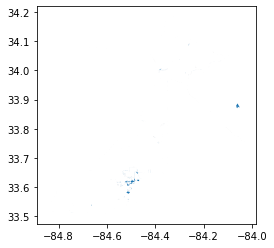

In [26]:
#Extremely small difference
shp_difference = gp.overlay(source_shapes,vest_shapes,how='symmetric_difference')
shp_difference.plot()

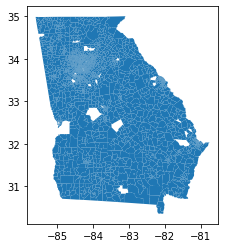

In [27]:
source_shapes.plot()

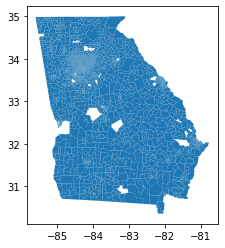

In [28]:
vest_shapes.plot()

In [29]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff != 0):
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]['county_prec'])
                if (diff>max_diff):
                    max_diff = diff
                    print("New max diff is: ", str(max_diff))
                    print(df.iloc[j]['county_prec'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]['county_prec'])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 5])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 5")

In [30]:
column_List = ['G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16USSRISA', 'G16USSDBAR', 'G16USSLBUC', 'G16PSCRECH',
       'G16PSCLHOS']
validater_row(validated_1[validated_1["final_merge"]=="both"],column_List)

There are  2625  total rows
0  of these rows have election result differences
2625  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 5
